数据分析和清洗

In [10]:
import jsonlines
import json


js = list(jsonlines.open("/home/cs/yangyuchen/yushengliao/Medical_LLM/data/USMLEdataset/data_clean/questions/US/train.jsonl"))
print(js[0])
new_js = [{"input":d['question']+"\nOptions: " + " ".join([f"{op}: {name}" for op, name in d['options'].items()]), "output": d['answer_idx'] } for d in js]
json.dump(new_js, open("data/usmle_train.json",'w'))

{'question': 'A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient?', 'answer': 'Nitrofurantoin', 'options': {'A': 'Ampicillin', 'B': 'Ceftriaxone', 'C': 'Ciprofloxacin', 'D': 'Doxycycline', 'E': 'Nitrofurantoin'}, 'meta_info': 'step2&3', 'answer_idx': 'E'}


In [3]:
import json

js = json.load(open("data/ner_results_chat_usmle_all.json"))
js[2]

{'input': 'An 11-month-old boy is brought to the physician by his adoptive mother for the evaluation of seizures and musty-smelling urine. His immunizations are up-to-date. His height and weight are both below the 10th percentile. He is pale and has blue eyes. He cannot pull himself up from a seated position to stand and does not crawl. Which of the following genetic principles best explains the variety of phenotypic traits seen in this patient?\nOptions: A: Variable expressivity B: Pleiotropy C: Incomplete penetrance D: Anticipation E: Loss of heterozygosity',
 'input_entities': ['evaluation',
  'seizures',
  'musty-smelling urine',
  'His immunizations',
  'His height and weight',
  'pale',
  'blue eyes',
  'phenotypic traits',
  'Variable expressivity',
  'Pleiotropy',
  'Incomplete penetrance',
  'Loss of',
  'heterozygosity'],
 'output': "The correct answer is B: Pleiotropy.\n\nPleiotropy refers to a single gene mutation that affects multiple, seemingly unrelated phenotypic traits

In [ ]:
import jsonlines
instructions = list(jsonlines.open("../instruction_datasets/instruction_dataall.jsonl"))

In [2]:
import pandas as pd
df = pd.read_csv("./data/umls_kg_filter.csv")

source
Clinical evaluation                                     16133
Surgical action (qualifier value)                       13861
Diagnostic intent (qualifier value)                     13300
Extension Namespace {1000000} (namespace concept)       10711
Skin of body                                            10118
INFLAMM                                                  8386
Morphologically abnormal structure                       8058
Medication Name                                          7977
Measurement (qualifier value)                            7790
Pathological developmental process (qualifier value)     7753
Name: count, dtype: int64


<Axes: >

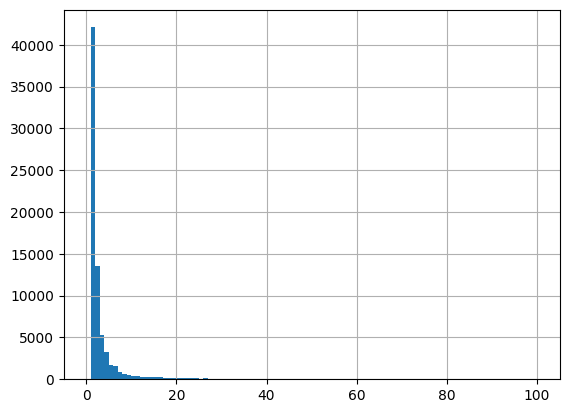

In [3]:
source_counts = df['source'].value_counts()
print(source_counts.head(10))
source_counts.hist(bins=100, range=(0,100))

In [28]:
# filter out rows with source occur more than 5 times
filtered_df = df[df['source'].isin(source_counts[source_counts <= 5].index)]
print(len(filtered_df))

# filter out rows with source equals to target
filtered_df = filtered_df[filtered_df['target']!=filtered_df['source']]
print(len(filtered_df))

filtered_df.to_csv("./data/umls_kg_filter_count_5.csv", index=False)

106503
97039


In [34]:
df['edge'].value_counts()

edge
has finding site                    222618
has associated morphology           126676
has method                          124943
has procedure site                   76044
interprets                           71921
possibly equivalent to               60997
has causative agent                  55257
has active ingredient                51121
has direct procedure site            45664
has pathological process             35034
has dose form                        27215
has intent                           23260
has occurrence                       17473
moved to                             16215
has interpretation                   14603
has direct morphology                12261
has direct substance                 11549
has direct device                    11348
has temporal context                  9815
has subject relationship context      9479
Name: count, dtype: int64

In [ ]:
from tqdm.auto import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")
import random

i = random.choice(instructions)
prompt = i['input'].strip()+" "+i['output'].strip()
doc = nlp(prompt)
from spacy import displacy
displacy.render(doc, style="ent")

In [2]:
import pickle
from transformers import AutoTokenizer
pkl_name = "int16_ep_0"
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(f'data/EntityDataset_chat_usmle/{pkl_name}.pkl','rb'))
tok = AutoTokenizer.from_pretrained('/home/cs/yangyuchen/yushengliao/Medical_LLM/FastChat/checkpoints/medical_llama_13b_chatv1.3/checkpoint-4974/')
dash_token="[DASH]"
tok.add_tokens([dash_token])

len(tok)

32001

array([[<Axes: title={'center': '0'}>]], dtype=object)

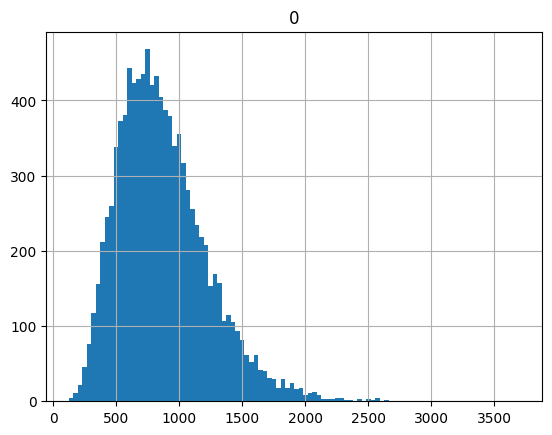

In [1]:
import pickle
import pandas as pd
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(f'data/EntityDataset_chat_usmle/8192_ep_0_new.pkl','rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])
input_len.hist(bins=100)

array([[<Axes: title={'center': '0'}>]], dtype=object)

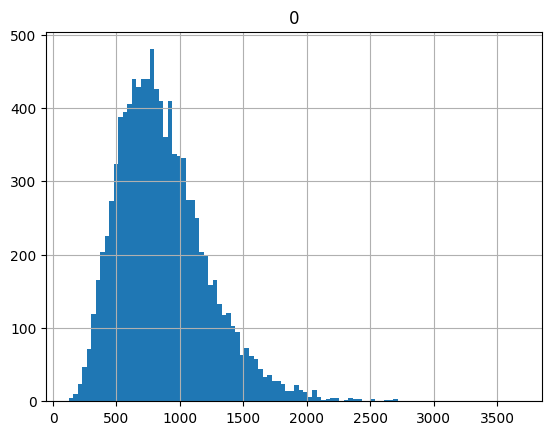

In [61]:
import pickle
import pandas as pd
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(f'data/EntityDataset_chat_usmle/8192_ep_0_new_no_dash.pkl','rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])
input_len.hist(bins=100)

In [66]:
import torch
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained('/home/cs/yangyuchen/yushengliao/Medical_LLM/vicuna-7b')
tok.add_tokens(['[DASH]'])
dst_size = len(input_ids_list)
for i in range(dst_size):
    print('input_shape: ', input_ids_list[i].shape)
    tp_index = torch.where(hard_position_type_ids_list[i]==2)[0]
    print('tp_index: ', tp_index)
    insert_index = torch.concat([tp_index[0].unsqueeze(0),tp_index[torch.where(tp_index[:-1] - tp_index[1:] != -1)[0] + 1]])
    print('insert_index: ', insert_index)
    new_input_ids = input_ids_list[i].clone()
    new_attention_ids = attention_mask_list[i].clone()
    for off_set, ii in enumerate(insert_index):
        new_input_ids = torch.concat([new_input_ids[:ii+off_set], torch.tensor([32000]), new_input_ids[ii+off_set:]])
        
    print('new_input_ids_shape: ', new_input_ids.shape)
    break

input_shape:  torch.Size([455])
tp_index:  tensor([156, 157, 158, 159, 195, 196, 197, 198, 199, 200, 250, 251, 252, 253,
        254, 255, 256, 257, 258, 259, 260])
insert_index:  tensor([156, 195, 250])
new_input_ids_shape:  torch.Size([458])
new_input_ids[torch.range(0, len(insert_index))+ insert_index]:  tensor([32000, 32000, 32000])


array([[<Axes: title={'center': '0'}>]], dtype=object)

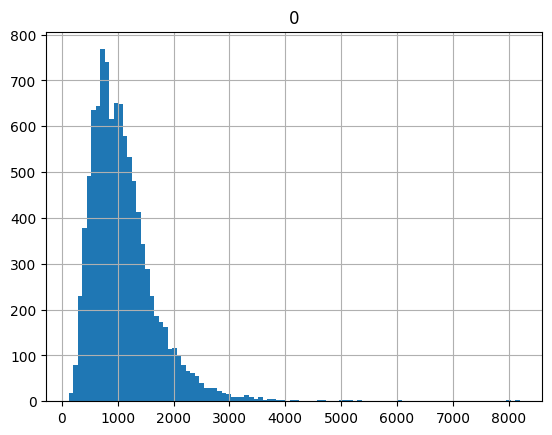

In [28]:
import pickle
import pandas as pd
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(f'data/EntityDataset_chat_usmle/8192_ep_0.pkl','rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])
input_len.hist(bins=100)

array([[<Axes: title={'center': '0'}>]], dtype=object)

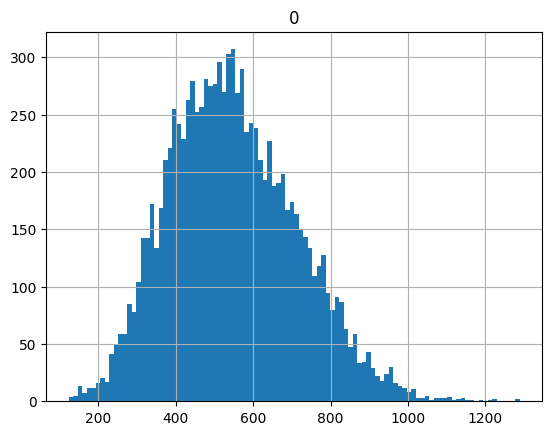

In [26]:
import pickle
import pandas as pd
input_ids_list, attention_mask_list, labels_list, prompts_list = pickle.load(open(f'data/BasicDataset_chat_usmle/ep_0.pkl','rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])
input_len.hist(bins=100)

array([[<Axes: title={'center': '0'}>]], dtype=object)

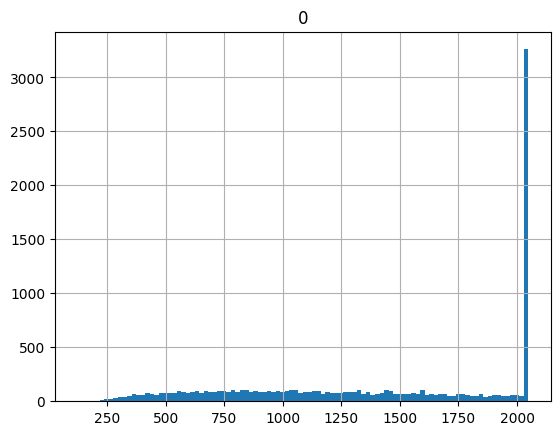

In [14]:
import pickle
import pandas as pd
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(f'data/EntityDataset_chat_usmle/int16_ep_0.pkl','rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])
input_len.hist(bins=100)

array([[<Axes: title={'center': '0'}>]], dtype=object)

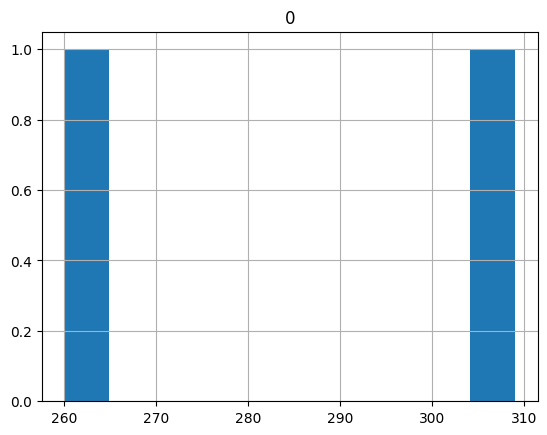

343


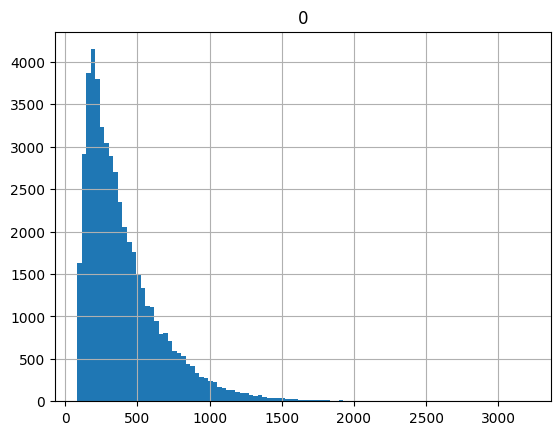

In [67]:
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer
import pickle
import pandas as pd
pkl_name = 'data/EntityDataset_medmcqa/ep_0.pkl'
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(pkl_name, 'rb'))
input_len = pd.DataFrame([len(x) for x in input_ids_list])
input_len.hist(bins=100)

tok = AutoTokenizer.from_pretrained('/home/cs/yangyuchen/yushengliao/Medical_LLM/FastChat/checkpoints/medical_llama_13b_chatv1.3/checkpoint-4974/')
tok.add_tokens(['[DASH]'])
i = 1
input_ids=input_ids_list[i]
attention_mask=attention_mask_list[i]
labels=labels_list[i]
hard_position_type_ids=hard_position_type_ids_list[i]
prompt=prompts_list[i]
print(input_ids.shape[-1])

tokens = tok.batch_decode(input_ids)
tokens = [t.replace('\n', '\\n') for t in tokens]
tokens = [f"{t}-{int(hard_position_type_ids[i])}-{int(int(labels[i])!=-100)}" for i,t in enumerate(tokens)]
attention_mask = attention_mask.numpy().tolist()
attention_mask = [[int(i) for i in row] for row in attention_mask]

matrix = attention_mask
row_index = tokens
col_index = tokens

max_row_length = max(len(row) for row in row_index)
max_col_length = max(len(col) for col in col_index)

# 打开文件
with open(f'{pkl_name}_{i}.txt', 'w') as f:
    f.write(prompt+ '\n\n')
    f.write('attention_mask:\n0:non-entity tokens，1:entity tokens, 2:triplet tokens, 3:triplet target tokens\n\n')
    # 写入列索引
    f.write(" " * max_row_length + "  " + "  ".join(col.ljust(max_col_length) for col in col_index) + '\n')
    # 写入行索引和每行的值
    for j, row in enumerate(matrix):
        f.write(row_index[j].ljust(max_row_length) + "  " + "  ".join(str(val).ljust(max_col_length) for val in row) + '\n')
        
# 创建DataFrame对象
df = pd.DataFrame(matrix, index=row_index, columns=col_index)

# 将DataFrame写入CSV文件
df.to_csv(f'{pkl_name}_{i}.csv')

In [33]:
import pandas as pd

edge = 'has definition of'

df = pd.read_csv("data/MRDEF_name.csv")
df.drop('CUI', axis=1, inplace=True)
df.rename(columns={'NAME': 'source', 'DEF': 'target'}, inplace=True)
df['edge'] = edge
kg = pd.read_csv('data/umls_kg_filter_count_5.csv')
kg_df = pd.concat([kg, df])
kg_df.to_csv('data/umls_kg_filter_count_5_with_def.csv', index=False)

In [16]:
import jsonlines

js = list(jsonlines.open("data/medmcqa/train.json"))

In [17]:
import pandas as pd
df = pd.DataFrame(js)
df = df[df['exp'].notnull()]
df = df[df['choice_type'].isin(['single'])]
df

,question,exp,cop,opa,opb,opc,opd,subject_name,topic_name,id,choice_type
0,Chronic urethral obstruction due to benign pri...,Chronic urethral obstruction because of urinar...,3,Hyperplasia,Hyperophy,Atrophy,Dyplasia,Anatomy,Urinary tract,e9ad821a-c438-4965-9f77-760819dfa155,single
1,Which vitamin is supplied from only animal sou...,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,3,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,Biochemistry,Vitamins and Minerals,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,single
4,Growth hormone has its effect on growth through?,"Ans. is 'b' i.e., IGI-1GH has two major functi...",2,Directly,IG1-1,Thyroxine,Intranuclear receptors,Physiology,None,dc6794a3-b108-47c5-8b1b-3b4931577249,single
5,Scrub typhus is transmitted by: September 2004,Ans. C i.e. Mite,3,Louse,Tick,Mite,Milk,Social & Preventive Medicine,None,5ab84ea8-12d1-47d4-ab22-668ebf01e64c,single
7,Per rectum examination is not a useful test fo...,PILONIDAL SINUS/DISEASE (Jeep Bottom; Driver's...,3,Anal fissure,Hemorrhoid,Pilonidal sinus,Rectal ulcer,Surgery,Urology,f3bf8583-231b-4b7a-828c-179b0f9ccdd9,single
...,...,...,...,...,...,...,...,...,...,...,...
182810,Cholesteatoma is seen in:,"(b) CSOM(Ref. Cummings, 6th ed., 2141)Choleste...",2,ASOM,CSOM,Secretory Otitis media,Otosclerosis,ENT,Disorders of Middle Ear (Otitis Media),934a6ba8-1573-4605-8a5e-fce2721155ca,single
182813,Enzyme replacement therapy is used for-,"Ans. is 'a' i.e., Gaucher's disease * Alglucer...",1,Gaucher's disease,Krabbe's disease,Metachromatic leukodystrophy,Tay Sach's disease,Biochemistry,Enzymes,5d4f09e3-65b1-4e92-84ad-b06ad40cd7cc,single
182815,Organism that causes emphysematous cholecystit...,Ref: Harrison's 18th editionExplanation:Emphys...,3,Salmonella typhi,Cytomegalovirus,Clostridium perfringens,Bacteroides,Medicine,Gall Bladder,ca769633-3650-4209-8d22-b81a2e171d25,single
182817,Most common site for extra mammary Paget&;s di...,.It is superficial manifestation of an intradu...,1,Vulva,Vagina,Penis,Anus,Surgery,Urology,04519631-61e3-4ef4-b2d6-c352cf349ded,single


In [18]:
from tqdm import tqdm
from transformers import AutoTokenizer
tqdm.pandas()

tok = AutoTokenizer.from_pretrained("/home/cs/yangyuchen/yushengliao/Medical_LLM/vicuna-7b")
df['input'] = df.progress_apply(lambda x : f"{x['question']} Options: {', '.join(['A: ' + x['opa'],'B: ' + x['opb'],'C: ' + x['opc'],'D: ' + x['opd']])}", axis=1)
df['output'] = df.progress_apply(lambda x : f"{['A','B','C','D'][x['cop']-1]} is the right answer. Explanation: {x['exp']}", axis=1)
df['input_len'] = df.progress_apply(lambda x : len(tok(x['input'])['input_ids']), axis=1)
df['output_len'] = df.progress_apply(lambda x : len(tok(x['output'])['input_ids']), axis=1)
df

 73%|███████▎  | 77846/106370 [00:00<00:00, 89657.00it/s]

100%|██████████| 106370/106370 [00:36<00:00, 2908.17it/s]


,question,exp,cop,opa,opb,opc,opd,subject_name,topic_name,id,choice_type,input,output,input_len,output_len
0,Chronic urethral obstruction due to benign pri...,Chronic urethral obstruction because of urinar...,3,Hyperplasia,Hyperophy,Atrophy,Dyplasia,Anatomy,Urinary tract,e9ad821a-c438-4965-9f77-760819dfa155,single,Chronic urethral obstruction due to benign pri...,C is the right answer. Explanation: Chronic ur...,57,122
1,Which vitamin is supplied from only animal sou...,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,3,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,Biochemistry,Vitamins and Minerals,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,single,Which vitamin is supplied from only animal sou...,C is the right answer. Explanation: Ans. (c) V...,39,157
4,Growth hormone has its effect on growth through?,"Ans. is 'b' i.e., IGI-1GH has two major functi...",2,Directly,IG1-1,Thyroxine,Intranuclear receptors,Physiology,None,dc6794a3-b108-47c5-8b1b-3b4931577249,single,Growth hormone has its effect on growth throug...,B is the right answer. Explanation: Ans. is 'b...,47,161
5,Scrub typhus is transmitted by: September 2004,Ans. C i.e. Mite,3,Louse,Tick,Mite,Milk,Social & Preventive Medicine,None,5ab84ea8-12d1-47d4-ab22-668ebf01e64c,single,Scrub typhus is transmitted by: September 2004...,C is the right answer. Explanation: Ans. C i.e...,39,20
7,Per rectum examination is not a useful test fo...,PILONIDAL SINUS/DISEASE (Jeep Bottom; Driver's...,3,Anal fissure,Hemorrhoid,Pilonidal sinus,Rectal ulcer,Surgery,Urology,f3bf8583-231b-4b7a-828c-179b0f9ccdd9,single,Per rectum examination is not a useful test fo...,C is the right answer. Explanation: PILONIDAL ...,45,291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182810,Cholesteatoma is seen in:,"(b) CSOM(Ref. Cummings, 6th ed., 2141)Choleste...",2,ASOM,CSOM,Secretory Otitis media,Otosclerosis,ENT,Disorders of Middle Ear (Otitis Media),934a6ba8-1573-4605-8a5e-fce2721155ca,single,"Cholesteatoma is seen in: Options: A: ASOM, B:...",B is the right answer. Explanation: (b) CSOM(R...,38,63
182813,Enzyme replacement therapy is used for-,"Ans. is 'a' i.e., Gaucher's disease * Alglucer...",1,Gaucher's disease,Krabbe's disease,Metachromatic leukodystrophy,Tay Sach's disease,Biochemistry,Enzymes,5d4f09e3-65b1-4e92-84ad-b06ad40cd7cc,single,Enzyme replacement therapy is used for- Option...,A is the right answer. Explanation: Ans. is 'a...,52,99
182815,Organism that causes emphysematous cholecystit...,Ref: Harrison's 18th editionExplanation:Emphys...,3,Salmonella typhi,Cytomegalovirus,Clostridium perfringens,Bacteroides,Medicine,Gall Bladder,ca769633-3650-4209-8d22-b81a2e171d25,single,Organism that causes emphysematous cholecystit...,C is the right answer. Explanation: Ref: Harri...,53,264
182817,Most common site for extra mammary Paget&;s di...,.It is superficial manifestation of an intradu...,1,Vulva,Vagina,Penis,Anus,Surgery,Urology,04519631-61e3-4ef4-b2d6-c352cf349ded,single,Most common site for extra mammary Paget&;s di...,A is the right answer. Explanation: .It is sup...,39,153


100%|██████████| 106370/106370 [00:00<00:00, 147561.62it/s]


,question,exp,cop,opa,opb,opc,opd,subject_name,topic_name,id,choice_type,input,output,input_len,output_len,tokens_num
0,Chronic urethral obstruction due to benign pri...,Chronic urethral obstruction because of urinar...,3,Hyperplasia,Hyperophy,Atrophy,Dyplasia,Anatomy,Urinary tract,e9ad821a-c438-4965-9f77-760819dfa155,single,Chronic urethral obstruction due to benign pri...,C is the right answer. Explanation: Chronic ur...,57,122,179
1,Which vitamin is supplied from only animal sou...,Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. ...,3,Vitamin C,Vitamin B7,Vitamin B12,Vitamin D,Biochemistry,Vitamins and Minerals,e3d3c4e1-4fb2-45e7-9f88-247cc8f373b3,single,Which vitamin is supplied from only animal sou...,C is the right answer. Explanation: Ans. (c) V...,39,157,196
4,Growth hormone has its effect on growth through?,"Ans. is 'b' i.e., IGI-1GH has two major functi...",2,Directly,IG1-1,Thyroxine,Intranuclear receptors,Physiology,None,dc6794a3-b108-47c5-8b1b-3b4931577249,single,Growth hormone has its effect on growth throug...,B is the right answer. Explanation: Ans. is 'b...,47,161,208
5,Scrub typhus is transmitted by: September 2004,Ans. C i.e. Mite,3,Louse,Tick,Mite,Milk,Social & Preventive Medicine,None,5ab84ea8-12d1-47d4-ab22-668ebf01e64c,single,Scrub typhus is transmitted by: September 2004...,C is the right answer. Explanation: Ans. C i.e...,39,20,59
7,Per rectum examination is not a useful test fo...,PILONIDAL SINUS/DISEASE (Jeep Bottom; Driver's...,3,Anal fissure,Hemorrhoid,Pilonidal sinus,Rectal ulcer,Surgery,Urology,f3bf8583-231b-4b7a-828c-179b0f9ccdd9,single,Per rectum examination is not a useful test fo...,C is the right answer. Explanation: PILONIDAL ...,45,291,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182810,Cholesteatoma is seen in:,"(b) CSOM(Ref. Cummings, 6th ed., 2141)Choleste...",2,ASOM,CSOM,Secretory Otitis media,Otosclerosis,ENT,Disorders of Middle Ear (Otitis Media),934a6ba8-1573-4605-8a5e-fce2721155ca,single,"Cholesteatoma is seen in: Options: A: ASOM, B:...",B is the right answer. Explanation: (b) CSOM(R...,38,63,101
182813,Enzyme replacement therapy is used for-,"Ans. is 'a' i.e., Gaucher's disease * Alglucer...",1,Gaucher's disease,Krabbe's disease,Metachromatic leukodystrophy,Tay Sach's disease,Biochemistry,Enzymes,5d4f09e3-65b1-4e92-84ad-b06ad40cd7cc,single,Enzyme replacement therapy is used for- Option...,A is the right answer. Explanation: Ans. is 'a...,52,99,151
182815,Organism that causes emphysematous cholecystit...,Ref: Harrison's 18th editionExplanation:Emphys...,3,Salmonella typhi,Cytomegalovirus,Clostridium perfringens,Bacteroides,Medicine,Gall Bladder,ca769633-3650-4209-8d22-b81a2e171d25,single,Organism that causes emphysematous cholecystit...,C is the right answer. Explanation: Ref: Harri...,53,264,317
182817,Most common site for extra mammary Paget&;s di...,.It is superficial manifestation of an intradu...,1,Vulva,Vagina,Penis,Anus,Surgery,Urology,04519631-61e3-4ef4-b2d6-c352cf349ded,single,Most common site for extra mammary Paget&;s di...,A is the right answer. Explanation: .It is sup...,39,153,192


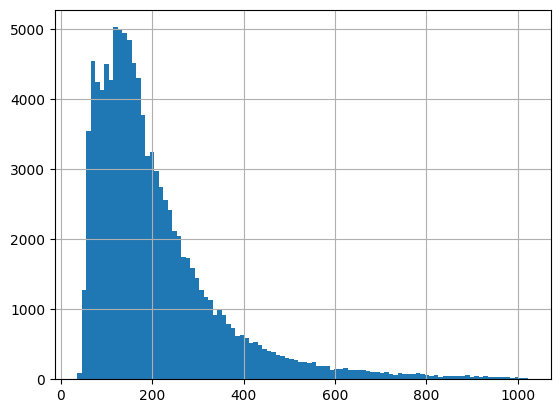

In [19]:
df['tokens_num'] = df.progress_apply(lambda x : x['input_len']+x['output_len'], axis=1)
df = df[df['tokens_num']<1024]
df['tokens_num'].hist(bins=100)
df

In [21]:
js = df[['input','output']].to_dict('records')

import json
json.dump(js, open("data/medmcqa_train.json",'w'))

In [22]:
import json

js = json.load(open("data/medmcqa_train.json"))
js[101]

{'input': 'Which of the following vitamin enhances intestinal absorption of calcium? Options: A: Vitamin D, B: Vitamin K, C: Vitamin B1, D: Vitamin B2',
 'output': 'A is the right answer. Explanation: Vitamin Functions Deficiency Disease D Maintenance of calcium balance Enhances intestinal absorption of Ca2+ and mobilizes bone mineral Regulation of gene expression and cell differentiation Rickets = poor mineralization of bone Osteomalacia = bone demineralization Reference: Harper; 30th edition; Page no: 550'}

In [82]:
import json

js2 = json.load(open("/home/cs/yangyuchen/guoyiqiu/kg_llm/data/kg_chat_usmle_10178.json"))

for i in js2:
    print(i)
    break

{'input': 'A 4-year-old boy presents to the opthalmologist for a down- and inward dislocation of the lens in his left eye. On physical exam, the boy has a marfanoid habitus and mental retardation. Biochemical tests were performed to locate the exact defect in this boy. It was found that there was a significant reduction of the conversion of 5,10-methyltetrahydrofolate to 5-methyltetrahydrofolate. Which of the following is the diagnosis?\nOptions: A: Marfan syndrome B: Homocystinuria C: Alkaptonuria D: Phenylketonuria E: Maple syrup disease', 'input_entities': ['mental retardation', 'Marfan syndrome', 'Homocystinuria'], 'output': 'The correct answer is B: Homocystinuria.\n\nHomocystinuria is an autosomal recessive disorder that results from a deficiency in cystathionine beta-synthase (CBS), which is responsible for the conversion of homocysteine to cystathionine. This leads to the accumulation of homocysteine and methionine in the blood and urine.\n\nIn this case, the significant reduct

In [83]:
tokens2 = [tok(i['input']+i['output']) for i in js2]

In [84]:
import pandas as pd

len_tokens2 = pd.DataFrame([len(t['input_ids']) for t in tokens2])
len_tokens2.sum()

0    5119632
dtype: int64

In [2]:
import json
import pandas as pd

js = json.load(open("data/kg_medmcqa_105639.json"))
df = pd.DataFrame(js)
df

,input,input_entities,output,output_entities,input_triplets,output_triplets
0,Chronic urethral obstruction due to benign pri...,[hyperplasia],C is the right answer. Explanation: Chronic ur...,[],"[[138401, 131685, 129735, 123687, 103499, 1929...",[]
1,Which vitamin is supplied from only animal sou...,[],C is the right answer. Explanation: Ans. (c) V...,[],[],[]
2,Growth hormone has its effect on growth throug...,[Intranuclear],B is the right answer. Explanation: Ans. is 'b...,[gluconeogenesis],"[[247032, 147889]]","[[161555, 102555, 161556, 216174]]"
3,Scrub typhus is transmitted by: September 2004...,[],C is the right answer. Explanation: Ans. C i.e...,[],[],[]
4,Per rectum examination is not a useful test fo...,"[Anal fissure, Hemorrhoid]",C is the right answer. Explanation: PILONIDAL ...,"[tion tissue, hairs, granuloma, sacral, rectov...","[[102000, 256961], [103038]]","[[102673], [115372], [123593, 126541, 113938, ..."
...,...,...,...,...,...,...
105634,"Cholesteatoma is seen in: Options: A: ASOM, B:...",[],B is the right answer. Explanation: (b) CSOM(R...,[],[],[]
105635,Enzyme replacement therapy is used for- Option...,[Enzyme replacement therapy],A is the right answer. Explanation: Ans. is 'a...,[],[[131902]],[]
105636,Organism that causes emphysematous cholecystit...,"[emphysematous cholecystitis, Clostridium]",C is the right answer. Explanation: Ref: Harri...,"[acute cholecystitis, gallbladder, Emphysemato...","[[129055], [122498, 248836, 122502, 122510, 12...","[[113689], [120352, 126310, 198316, 102291, 15..."
105637,Most common site for extra mammary Paget&;s di...,[],A is the right answer. Explanation: .It is sup...,"[Paget's disease of penis, Erythroplasia]",[],"[[117347], [101542]]"


In [15]:
df['e_num'] = df.apply(lambda x: len(x['input_entities'])+len(x['output_entities']), axis=1)
df_filter = df[df['e_num']>0]

json.dump(df_filter.to_dict('records'), open("data/kg_medmcqa_62620.json",'w'),)


In [57]:
import torch

m = torch.arange(25).view(5,5)
print(m)
h = torch.tensor([0,1,2,3,4])
m[[1,2,3],[1,2,3]]

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])


tensor([ 6, 12, 18])